In [1]:
import Plots as plt

In [67]:
#func(y, x) = sin.(2*π*x) .* cos.(2*π*y) .+ 0.1
#func(y, x) = sin.(2*π*(x-y)).+ 0.1

#σ = 0.1
#func(y, x) = exp.(-(x - 3/4)^2/σ^2 - (y - 1/4)^2/σ^2).+ 0.0

#τ = 0.5
#func(y, x) = exp.(-(1 - abs.(x - y))/τ).+ 0.0

τ = 0.5
func(y, x) = exp.(-(x - y)/τ) * (x > y)

func (generic function with 1 method)

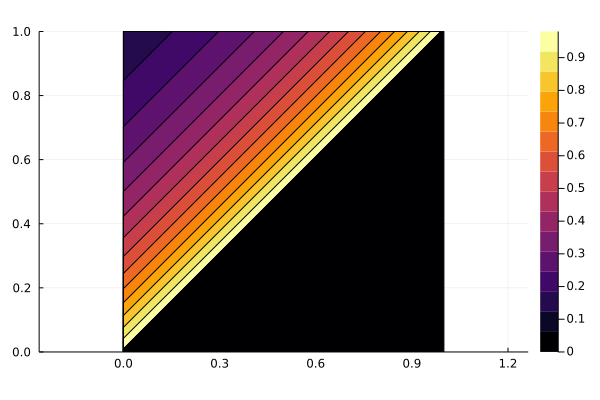

In [68]:
x = y = range(0, stop=1, length=100)
plt.plot(x, y, func, st=:contourf, aspect_ratio=:equal)

# Exact reference results

In [30]:
import MultiQuad: dblquad

In [31]:
#res_sq, error_sq = dblquad(
#    func, 0, 1, 0, 1, rtol=1e-12, atol=1e-12)

#println("error = $error_sq")
#println("res = $res_sq")

In [32]:
res_trid, error_trid = dblquad(
    func, 0, 1, (x)->x, (x)->1, rtol=1e-12, atol=1e-12)

res_tri, error_tri = dblquad(
    #func, 0, 1, (x)->x, (x)->1, rtol=1e-12, atol=1e-12)
    func, 0, 1, (x)->0, (x)->x, rtol=1e-12, atol=1e-12)

println("res_tri = $res_tri ± $error_tri")

res_sq = res_tri + res_trid
error_sq = error_tri + error_trid

println("res_sq  = $res_sq ± $error_sq")

res_tri = 0.14849853757254053 ± 9.990414676865793e-13
res_sq  = 0.2969970751450811 ± 1.998083421993587e-12


# Quasi Monte Carlo integration

On the unit square

In [33]:
import Sobol as sb

In [34]:
d = 2
N = 512
s = sb.SobolSeq(d)
Y = hcat([sb.next!(s) for i = 1:N]...)

2×512 Matrix{Float64}:
 0.5  0.75  0.25  0.375  0.875  0.625  …  0.501953    0.00195312  0.00292969
 0.5  0.25  0.75  0.375  0.875  0.125     0.00195312  0.501953    0.250977

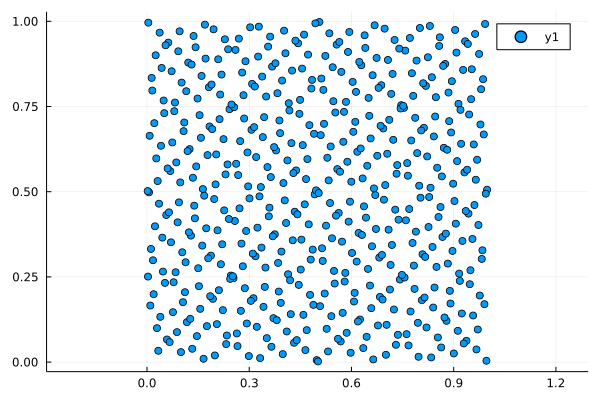

In [35]:
plt.plot(Y[1, :], Y[2, :], seriestype=:scatter, aspect_ratio=:equal)

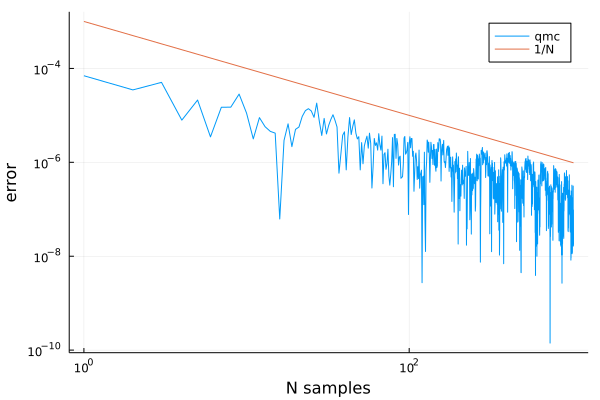

In [36]:
function sample_sq(N, seq)
    acc = 0.
    for n in 1:N
        v = sb.next!(seq)
        x, y = v[1], v[2]
        val = func(x, y)
        acc += val
    end
    res = acc / N
    return res
end

seq = sb.SobolSeq(2)

N = 1024
M = 1024

res = Array{Float64}(undef, M)
acc = 0.

for m in 1:M
    r = sample_sq(N, seq)
    acc += r
    res = vcat(res, )
    res[m] = acc / m
end

plt.plot(abs.(res .- res_sq), lab="qmc")

x = 0.001 ./ collect(1:M)
plt.plot!(x, lab="1/N")

plt.yaxis!("error", :log10)
plt.xaxis!("N samples", :log10)

# Quasi Monte Carlo

On the simplex

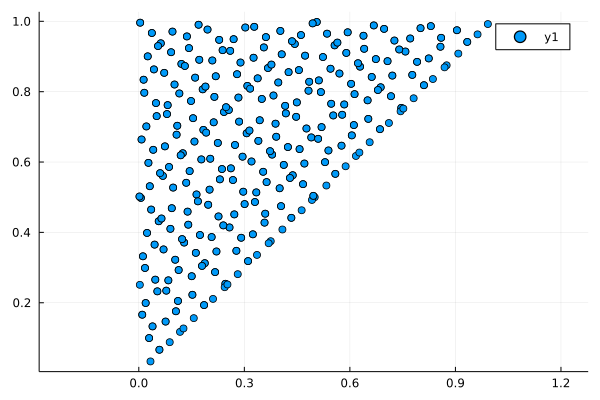

In [37]:
Yt = sort(Y, dims=1)
plt.plot(Yt[1, :], Yt[2, :], seriestype=:scatter, aspect_ratio=:equal)

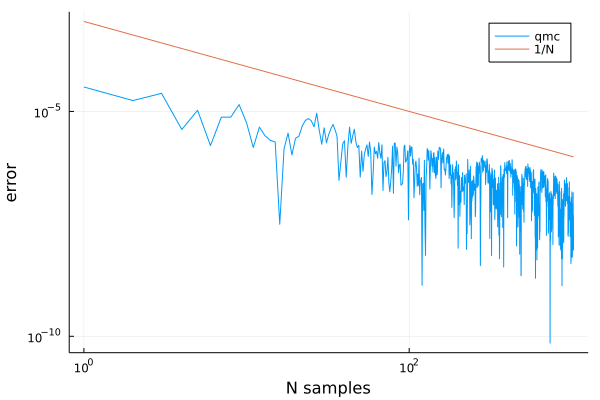

In [39]:
function sample_tri(N, seq)
    acc = 0.
    for n in 1:N
        v = sb.next!(seq)
        v = sort(v)
        x, y = v[1], v[2]
        val = func(x, y)
        acc += val
    end
    jac = 1/2 # Jacobian of sort transform
    res = acc / N * jac
    return res
end

seq = sb.SobolSeq(2)

N = 1024
M = 1024

res = Array{Float64}(undef, M)
acc = 0.

for m in 1:M
    r = sample_tri(N, seq)
    acc += r
    res = vcat(res, )
    res[m] = acc / m
end

plt.plot(abs.(res .- res_tri), lab="qmc")

x = 0.001 ./ collect(1:M)
plt.plot!(x, lab="1/N")

plt.yaxis!("error", :log10)
plt.xaxis!("N samples", :log10)

# Standard exponential model function

$$ 
h(v) = e^{-v / \tau}
$$

$$
x(v) = 1 - e^{-v/\tau}
$$

$$
v = -\tau \log(1 - x)
$$

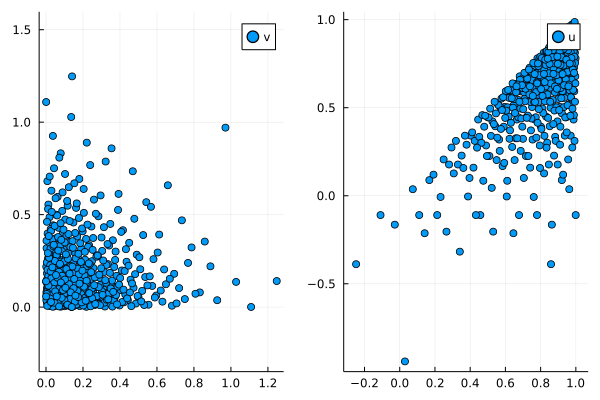

In [54]:
d = 2
N = 512
s = sb.SobolSeq(d)
x = hcat([sb.next!(s) for i = 1:N]...)

τ = 0.2
v = -τ * log.(1 .- x)

v1 = v[1, :]
v2 = v[2, :]

u1 = 1 .- v1
u2 = u1 .- v2

pv = plt.plot(v1, v2, seriestype=:scatter, aspect_ratio=:equal, lab="v")
pu = plt.plot(u1, u2, seriestype=:scatter, aspect_ratio=:equal, lab="u")
plt.plot(pv, pu, layout=(1, 2))

# Modified $v$ range

$$
h(v) = e^{-v / \tau}
$$

$$
x(v) 
= 
\frac{\int_0^v d\bar{v} h(v)}{\int_0^1 d\bar{v} h(v)}
= \frac{1 - e^{-v/\tau}}{1 - e^{-1/\tau}}
$$


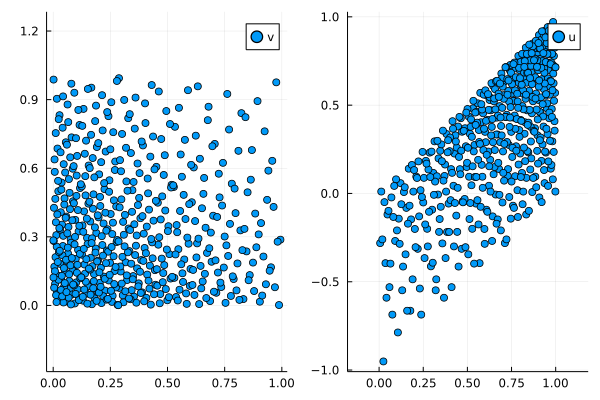

In [65]:
d = 2
N = 512
s = sb.SobolSeq(d)
x = hcat([sb.next!(s) for i = 1:N]...)

τ = 0.5
η = 1 - exp(-1/τ)
v = -τ * log.(1 .- η*x)

v1 = v[1, :]
v2 = v[2, :]

u1 = 1 .- v1 
u2 = u1 .- v2

pv = plt.plot(v1, v2, seriestype=:scatter, aspect_ratio=:equal, lab="v")
pu = plt.plot(u1, u2, seriestype=:scatter, aspect_ratio=:equal, lab="u")
plt.plot(pv, pu, layout=(1, 2))

# Modified $v$ range with sort transform

$$
h(v) = e^{-v / \tau}
$$

$$
x(v) 
= 
\frac{\int_0^v d\bar{v} h(v)}{\int_0^1 d\bar{v} h(v)}
= \frac{1 - e^{-v/\tau}}{1 - e^{-1/\tau}}
$$


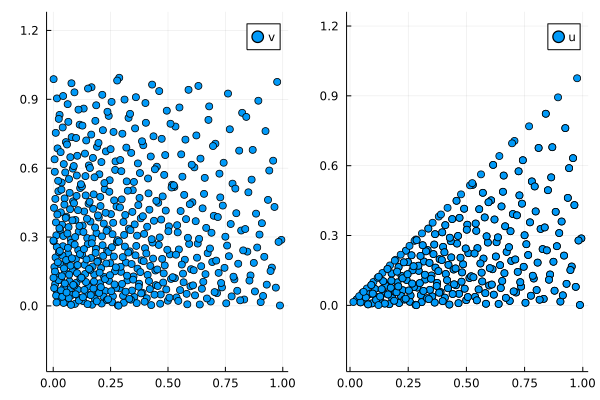

In [66]:
d = 2
N = 512
s = sb.SobolSeq(d)
x = hcat([sb.next!(s) for i = 1:N]...)

τ = 0.5
η = 1 - exp(-1/τ)
v = -τ * log.(1 .- η*x)

v1 = v[1, :]
v2 = v[2, :]

u = sort(v, dims=1, rev=true)
u1 = u[1, :] 
u2 = u[2, :]

pv = plt.plot(v1, v2, seriestype=:scatter, aspect_ratio=:equal, lab="v")
pu = plt.plot(u1, u2, seriestype=:scatter, aspect_ratio=:equal, lab="u")
plt.plot(pv, pu, layout=(1, 2))